In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('default')
from model.model import *
from utils.misc import *
from data.load_data import CreateTestLoader

/Users/cuichen/miniconda3/envs/jax-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cuichen/miniconda3/envs/jax-env/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using GPU, %s' % torch.cuda.get_device_name()) if device == 'cuda' else print('Using CPU')

Using CPU


In [3]:
N = 256
if N == 128:
    omega = 20*np.pi
    max_level = 6
elif N == 256:
    omega = 40*np.pi
    max_level = 7
elif N == 512:
    omega = 80*np.pi
    max_level = 8
elif N == 1024:
    omega = 160*np.pi
    max_level = 9
elif N == 2048:
    omega = 320*np.pi
    max_level = 10
    
gamma_val = 0.0

m = n = N
h = 1/m
M = 8
src = [m // 2, n // 2]

In [4]:
DATASET = "cifar10"
batch = 1

In [5]:
test_loader = CreateTestLoader(N, batch, DATASET, src)
for b, kappa in test_loader:
    b, kappa = b, kappa

In [6]:
config = {}
config["M"]              = 1
config["NO_Type"]        = "FNO" 
config["modes"]          = [12,12,12,12]
config["depths"]         = [3,3,9,3]
config["dims"]           = [36,36,36,36]
config["drop_path_rate"] = 0.3
config["drop"]           = 0.
config["padding"]        = 9
config["act"]            = "gelu"
config["xavier_init"]    = 1e-2

config["max_iter_num"]    = 100
config["error_threshold"] = 1e-6

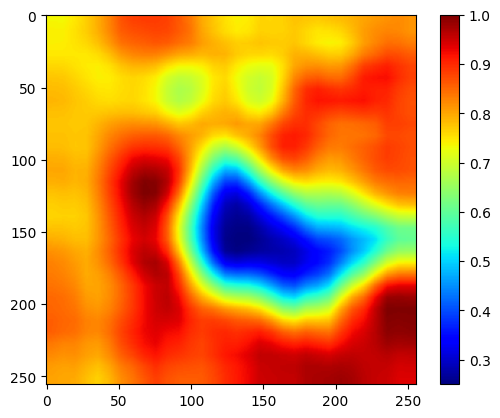

In [7]:
plt.imshow(kappa[0,0], cmap="jet")
plt.colorbar()

In [8]:
gamma = absorbing_layer(gamma_val, kappa[0, 0].cpu(), [16, 16], omega)
kappa, gamma = kappa.to(device), gamma.to(device)
Helm = Helmholtz(kappa, gamma, omega)

In [9]:
b = torch.zeros(1, 1, m, n, dtype=torch.cfloat, device=device)
b[:, :, src[0], src[1]] = 1.0 / h**2

In [10]:
model = WaveADR(config).to(device)
total_params = count_parameters(model)
print("Total parameters: ", total_params)

Using Fourier Neural Operator
Total parameters:  13939337


In [11]:
checkpoint = "expriments/checkpoint/model.pth"
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()

WaveADR(
  (neural_operator): sFNO_epsilon_v2(
    (lifting_layers): ModuleList(
      (0): Conv2d(3, 36, kernel_size=(1, 1), stride=(1, 1))
      (1-3): 3 x Sequential(
        (0): LayerNorm()
        (1): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (stages): ModuleList(
      (0): Sequential(
        (0): IO_ResNetblock(
          (IO): IO_layer(
            (W): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1))
            (IO): fourier_conv_2d()
            (act): GELU(approximate='none')
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (pwconv1): Conv2d(36, 144, kernel_size=(1, 1), stride=(1, 1))
          (act): GELU(approximate='none')
          (pwconv2): Conv2d(144, 36, kernel_size=(1, 1), stride=(1, 1))
          (norm1): LayerNorm()
          (norm2): LayerNorm()
          (drop_path): Identity()
        )
        (1): IO_ResNetblock(
          (IO): IO_layer(
            (W): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1)

In [12]:
lam_max = model.setup_cheby(kappa, gamma, omega, max_level)
lam_max

[272704913408.0,
 16734267392.0,
 980131584.0,
 227473296.0,
 217220944.0,
 193455632.0,
 136607824.0]

In [13]:
T, Tx, Ty, LT, alphas = model.setup(down(kappa.float()), omega, src, max_level)
T, Tx, Ty, LT = T.repeat(1, 8, 1, 1), Tx.repeat(1, 8, 1, 1), Ty.repeat(1, 8, 1, 1), LT.repeat(1, 8, 1, 1)

/Users/cuichen/miniconda3/envs/jax-env/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
for alpha in alphas:
    print(alpha.item())

4.086119651794434
-0.04305668920278549
-0.015636462718248367
-0.0019263522699475288
0.002614240627735853


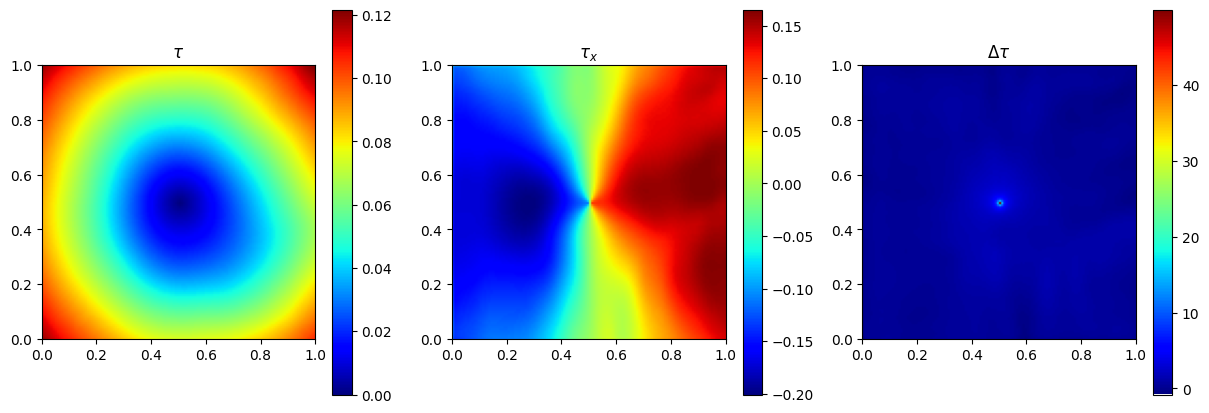

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5)) 

im = ax1.imshow(T[0,0].detach(), cmap="jet", extent=[0,1,0,1])
ax1.set_title(r'$\tau$', fontsize=12)
cbar = fig.colorbar(im, ax=ax1) 

im = ax2.imshow(Tx[0,0].detach(), cmap="jet", extent=[0,1,0,1])
ax2.set_title(r'$\tau_x$', fontsize=12)
cbar = fig.colorbar(im, ax=ax2) 

im = ax3.imshow(LT[0,0].detach(), cmap="jet", extent=[0,1,0,1])
ax3.set_title(r'$\Delta\tau$', fontsize=12)
cbar = fig.colorbar(im, ax=ax3) 

In [16]:
max_iter  = 100
restart   = 20
with torch.no_grad():
    x, ress, gmres_time = model.test(
        b, kappa, omega, max_level, gamma_val, T, Tx, Ty, LT, lam_max, alphas, restart, max_iter
    )

15


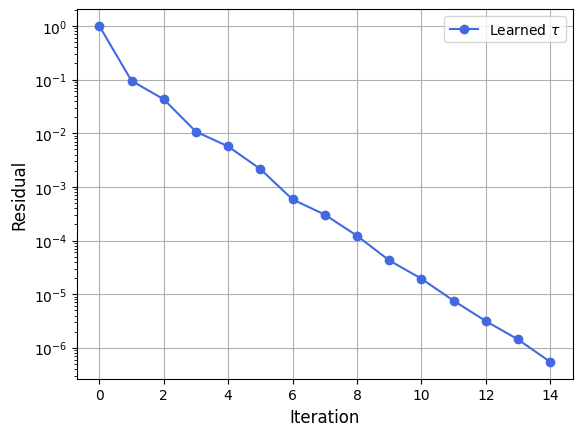

In [17]:
print(len(ress))
plt.semilogy(ress, label=r"Learned $\tau$", color='royalblue', marker='o', markersize=6)
plt.legend()
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.grid()

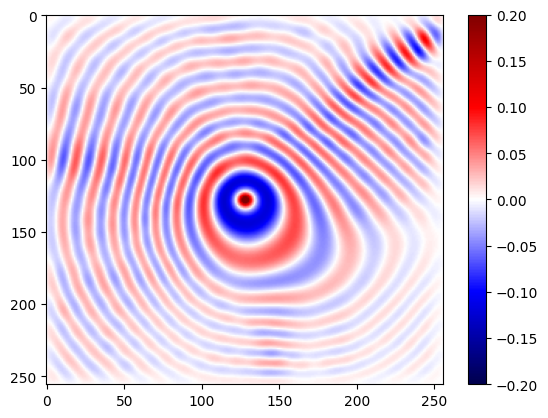

In [18]:
plt.imshow(x.reshape(m, n).real.cpu().detach().numpy(), cmap='seismic', aspect='auto', vmin=-0.2, vmax=0.2)
plt.colorbar()